In [1]:
%load_ext autoreload
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import cv2
import os

In [2]:
video_path = "C:/Users/paulo/Downloads/wagner.mp4"
dataframe_path = video_path.split('.')[0]+'_dataframe.pkl'
fps_extraction = 1

### Clustering Video Faces Using Its Frames

In [3]:
from faces_clustering import VideoClustering

from mtcnn_torch import MTCNN_Torch
from sphere_mtcnn import SphereMTCNN_Torch
from faces_viewport import MTCNN_tf, ViewportsFaceDetector

Using TensorFlow backend.


In [4]:
#mtcnn_torch = MTCNN_Torch()
mtcnn_tf = MTCNN_tf()
#viewports_torch = ViewportsFaceDetector(torch = True, width = 200, rows = 3, cols = 6, nms_th=0.25)
#viewports_tf = ViewportsFaceDetector(torch = False, width = 200, rows = 3, cols = 6, nms_th=0.25)

In [5]:
video_clustering = VideoClustering('senet50', mtcnn_tf, 'agglomerative', verbose=5)

Processing C:/Users/paulo/Downloads/wagner.mp4
extracting frames
Original video fps is 30. Extracting at each 30.0 frames
extracting embeddings



clustering


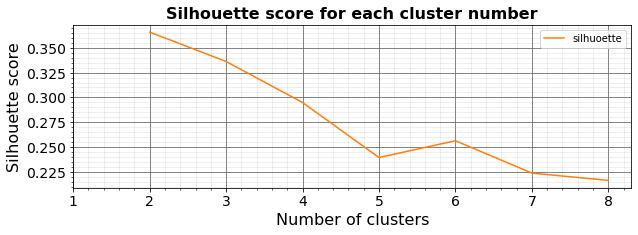

Best cluster number is 2


In [6]:
res = video_clustering.cluster(video_path, fps=fps_extraction)

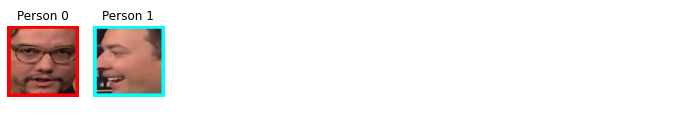

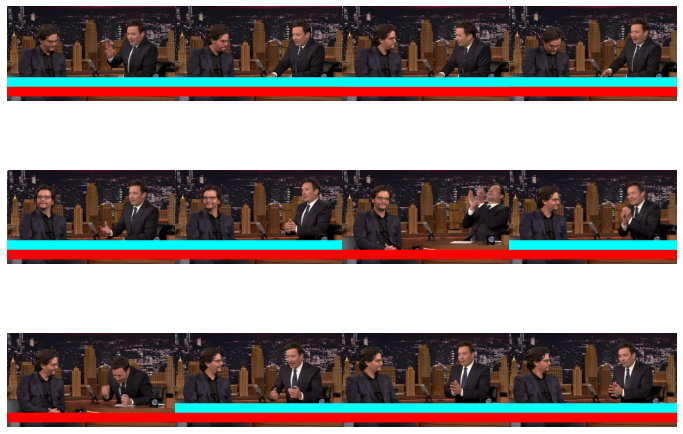

In [7]:
video_clustering.display_timeline(lines = True, limit = 12)

In [8]:
#adjusting and saving dataframe

columns_subtitles = ['frames','urls', 'bounds', video_clustering.cluster_column]
actors_pos =  res[columns_subtitles].copy()
actors_pos.columns = ['frames','urls', 'bounds', 'actors_id']
actors_pos.sort_values(by=['frames'], inplace = True)
actors_pos.reset_index(drop=True, inplace = True)

actors_pos.to_pickle(dataframe_path)

### Positions of Actors

In [4]:
actors_pos = pd.read_pickle(dataframe_path)

In [5]:
#obtaining the center position of the bounding boxes

actors_pos['center_face_pos'] = actors_pos.bounds.apply(lambda x: np.array(x).mean(axis = 0))

### Converting Coordinates

In [6]:
max_y, max_x, _  = cv2.imread(actors_pos.urls[0]).shape

In [7]:
def lat_long_from_xy(pos_xy, max_x = max_x, max_y = max_y):
    x,y = pos_xy

    d_y = (y/max_y)*180
    d_x = (x/max_x)*360

    lat = d_y-90    #where 90 is the bottom and -90 is the top
    long = d_x - 180  #where 180 is the right and -180 is the left

    return {'lat': lat, 'long': long}

In [8]:
actors_pos['lat_long'] = actors_pos.center_face_pos.apply(lat_long_from_xy)

### Time Reference

In [9]:
cap=cv2.VideoCapture(video_path)
original_fps = int(round(cap.get(cv2.CAP_PROP_FPS)))

actors_pos['time'] = actors_pos.frames/original_fps
actors_pos.head()

,frames,urls,bounds,actors_id,center_face_pos,lat_long,time
0,30,D:/Movies/360Video/omelete\frame_30.jpg,"[(96, 393), (123, 396), (149, 399), (149, 430)...",1,"[122.625, 429.5]","{'lat': -9.46875, 'long': -157.0078125}",1.0
1,30,D:/Movies/360Video/omelete\frame_30.jpg,"[(1535, 397), (1561, 396), (1589, 395), (1589,...",2,"[1561.75, 429.875]","{'lat': -9.3984375, 'long': 112.828125}",1.0
2,30,D:/Movies/360Video/omelete\frame_30.jpg,"[(542, 417), (569, 415), (596, 414), (596, 450...",0,"[569.0, 451.0]","{'lat': -5.4375, 'long': -73.31250000000001}",1.0
3,30,D:/Movies/360Video/omelete\frame_30.jpg,"[(1043, 411), (1071, 413), (1100, 416), (1100,...",5,"[1071.375, 447.875]","{'lat': -6.0234375, 'long': 20.8828125}",1.0
4,30,D:/Movies/360Video/omelete\frame_30.jpg,"[(1820, 385), (1836, 384), (1855, 383), (1855,...",3,"[1837.125, 406.375]","{'lat': -13.8046875, 'long': 164.4609375}",1.0


In [10]:
time_reference = actors_pos[['time', 'actors_id','lat_long']].copy()

### Saving position by actors

In [11]:
time_reference.head()

,time,actors_id,lat_long
0,1.0,1,"{'lat': -9.46875, 'long': -157.0078125}"
1,1.0,2,"{'lat': -9.3984375, 'long': 112.828125}"
2,1.0,0,"{'lat': -5.4375, 'long': -73.31250000000001}"
3,1.0,5,"{'lat': -6.0234375, 'long': 20.8828125}"
4,1.0,3,"{'lat': -13.8046875, 'long': 164.4609375}"


In [12]:
def save_actor_positions(actor_id, time_reference, video_path, fps_extraction):
    positions_folder = f"{video_path.split('.')[0]}_actor_positions"
    if not os.path.isdir(positions_folder):
        os.mkdir(positions_folder)

    pos_file_path = f"{positions_folder}/actor_{actor_id}.csv"
    if os.path.exists(pos_file_path):
        print(f'{pos_file_path} already exists! File have not been created.')
        return pos_file_path

    time_positions = time_reference.loc[time_reference.actors_id == actor_id][['time']].copy()
    time_positions['lat'] = time_reference['lat_long'].apply(lambda x: x['lat'])
    time_positions['long'] = time_reference['lat_long'].apply(lambda x: x['long'])


    f = open(pos_file_path, 'a')
    f.write(f'fps_extraction:{fps_extraction}\n')
    time_positions.to_csv(f, index=False)
    f.close()
    return pos_file_path

In [13]:
default_args = [time_reference, video_path, fps_extraction]

_ = save_actor_positions(0, *default_args)
_ = save_actor_positions(1, *default_args)
_ = save_actor_positions(2, *default_args)
_ = save_actor_positions(3, *default_args)
_ = save_actor_positions(4, *default_args)
_ = save_actor_positions(5, *default_args)